# Housing Analysis in King County, Washington
## Linear Regression Analysis

## Business Challenge
#### A local realtor wants to know which features are affecting home prices the most in King County. The realtor does work in all of the areas of King County. A regression will help the client better understand which homes to show and when to highlight the important features to prospective home buyers. 
#### 'Important' features will be qualified as those features which most significantly affect the price of a home. 

In [65]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import csv

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import scipy.stats as stats
from statsFunctions import check_model as sf
from pltfunctions import hist_kde_plots as hk
from statsFunctions import calc_adjr_and_VIF as clc
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'data\CleanHousing.csv',index_col=0)
pd.options.display.float_format = '{:.2f}'.format

In [66]:
# checking for OLS assumptions:
# 1) the regression model is 'linear in parameters'
# 2) There is a random sampling of observations
# 3) The conditional mean should be zero, ie the expected value of the mean of the error terms should be zero
# 4) There is no multi-collinearity (no features can be derived from other features' values)
# 5) There is homoscedasticity and no autocorrelation
# 6) Error terms should be normally distributed

### Data description per following image
#### * The following data has been removed, however: id, date, sqft_above, sqft_basement, yr_renovated, lat, long, sqft_living15, and sqft_lot15

#### * Please refer to Mod2ProjectEDA.ipynb for an explanation of exclusions

![title](img/headers.png)

In [67]:
df.describe() # a look at the data, data has been cleaned and imported

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long
count,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00,14314.00
mean,455262.04,3.31,2.02,1927.73,14468.89,1.46,0.00,0.15,3.40,7.47,1970.80,47.55,-122.21
std,181700.32,0.91,0.69,726.95,39136.28,0.53,0.05,0.59,0.65,0.98,28.99,0.14,0.14
min,82000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,1900.00,47.16,-122.52
25%,310000.00,3.00,1.50,1380.00,5000.00,1.00,0.00,0.00,3.00,7.00,1952.00,47.45,-122.33
50%,427500.00,3.00,2.00,1830.00,7485.50,1.00,0.00,0.00,3.00,7.00,1974.00,47.56,-122.23
75%,576881.25,4.00,2.50,2380.00,10168.75,2.00,0.00,0.00,4.00,8.00,1996.00,47.68,-122.12
max,913000.00,33.00,7.50,7120.00,1651359.00,3.50,1.00,4.00,5.00,12.00,2015.00,47.78,-121.31


## Check for Multicollinearity in the data

In [68]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','yr_built','lat','long']

In [69]:
corr1 = df[features].corr()
corr1
# correlation table with target variable

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long
price,1.00,0.27,0.42,0.58,0.09,0.27,0.04,0.19,0.03,0.59,0.06,0.45,0.09
bedrooms,0.27,1.00,0.48,0.59,0.02,0.15,-0.04,0.02,0.02,0.30,0.16,-0.04,0.14
bathrooms,0.42,0.48,1.00,0.70,0.05,0.50,-0.03,0.06,-0.15,0.59,0.56,-0.03,0.25
sqft_living,0.58,0.59,0.70,1.00,0.15,0.33,-0.01,0.13,-0.08,0.68,0.36,-0.01,0.30
sqft_lot,0.09,0.02,0.05,0.15,1.00,-0.03,0.01,0.10,-0.01,0.08,0.04,-0.10,0.23
floors,0.27,0.15,0.50,0.33,-0.03,1.00,-0.02,-0.02,-0.28,0.45,0.52,0.04,0.14
waterfront,0.04,-0.04,-0.03,-0.01,0.01,-0.02,1.00,0.29,0.01,-0.02,-0.04,-0.04,-0.06
view,0.19,0.02,0.06,0.13,0.10,-0.02,0.29,1.00,0.02,0.10,-0.07,-0.04,-0.07
condition,0.03,0.02,-0.15,-0.08,-0.01,-0.28,0.01,0.02,1.00,-0.18,-0.35,-0.03,-0.10
grade,0.59,0.30,0.59,0.68,0.08,0.45,-0.02,0.10,-0.18,1.00,0.51,0.07,0.24


Text(0.5, 1.0, &#39;Heat Map with Target&#39;)

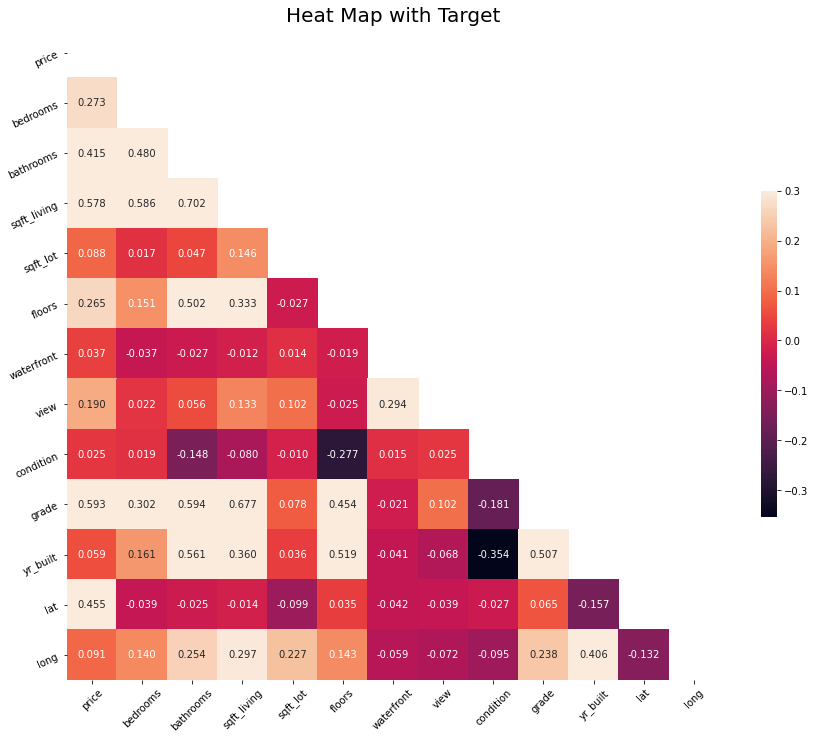

In [70]:
plt.figure(figsize=(15,12))
# cmap = sns.diverging_palette(300,10,as_cmap=True)
mask = np.triu(np.ones_like(corr1, dtype=bool))
chart = sns.heatmap(corr1, fmt='0.3f', mask=mask, annot=True, vmax=0.3, square=True, cbar_kws={"shrink": .5});
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_yticklabels(chart.get_xticklabels(),rotation=25)
plt.title("Heat Map with Target",fontsize=20)

In [71]:
features2 = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','yr_built','lat','long']
corr2 = df[features2].corr()
corr2
# correlation table with target variable

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long
bedrooms,1.00,0.48,0.59,0.02,0.15,-0.04,0.02,0.02,0.30,0.16,-0.04,0.14
bathrooms,0.48,1.00,0.70,0.05,0.50,-0.03,0.06,-0.15,0.59,0.56,-0.03,0.25
sqft_living,0.59,0.70,1.00,0.15,0.33,-0.01,0.13,-0.08,0.68,0.36,-0.01,0.30
sqft_lot,0.02,0.05,0.15,1.00,-0.03,0.01,0.10,-0.01,0.08,0.04,-0.10,0.23
floors,0.15,0.50,0.33,-0.03,1.00,-0.02,-0.02,-0.28,0.45,0.52,0.04,0.14
waterfront,-0.04,-0.03,-0.01,0.01,-0.02,1.00,0.29,0.01,-0.02,-0.04,-0.04,-0.06
view,0.02,0.06,0.13,0.10,-0.02,0.29,1.00,0.02,0.10,-0.07,-0.04,-0.07
condition,0.02,-0.15,-0.08,-0.01,-0.28,0.01,0.02,1.00,-0.18,-0.35,-0.03,-0.10
grade,0.30,0.59,0.68,0.08,0.45,-0.02,0.10,-0.18,1.00,0.51,0.07,0.24
yr_built,0.16,0.56,0.36,0.04,0.52,-0.04,-0.07,-0.35,0.51,1.00,-0.16,0.41


Text(0.5, 1.0, &#39;Heat Map without Target&#39;)

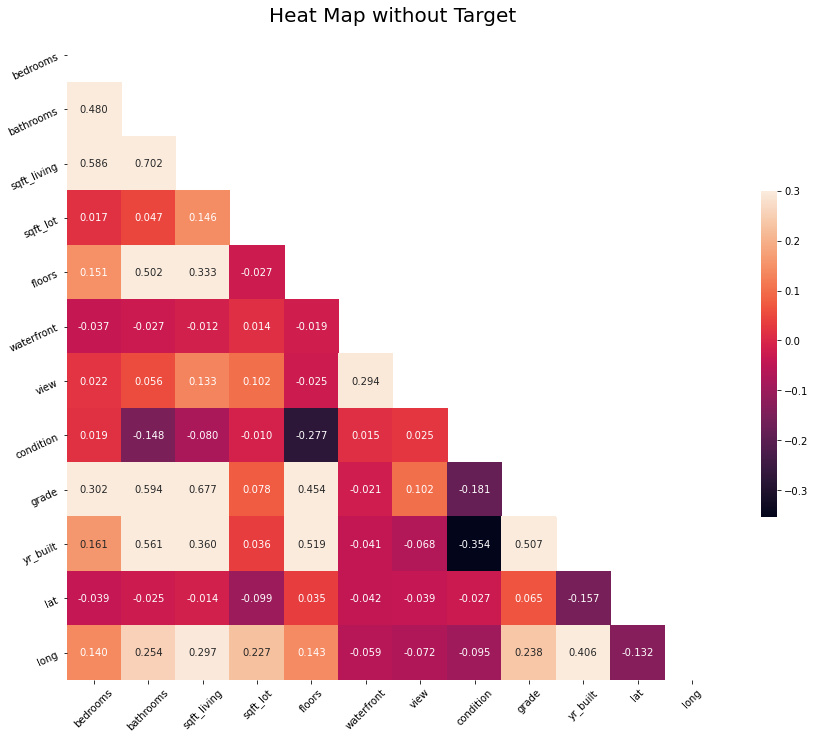

In [72]:
plt.figure(figsize=(15,12))
# cmap = sns.diverging_palette(300,10,as_cmap=True)
mask = np.triu(np.ones_like(corr2, dtype=bool))
chart = sns.heatmap(corr2,fmt='0.3f', mask=mask, annot=True, vmax=0.3, square=True, cbar_kws={"shrink": .5});
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_yticklabels(chart.get_xticklabels(),rotation=25)
plt.title("Heat Map without Target",fontsize=20)

### There are no features that have a high correlation (or a correlation approaching 1) that need to be removed from the dataset. We can continue with creating our model and answering our questions!

### This next sectiobn will create a linear regression to model the data using a test/train split of 20/80. 

In [73]:
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','yr_built','lat','long']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 20) # create test and train variables, assign random state for reproducibility

In [74]:
reg = LinearRegression(fit_intercept=True) # create linear regression
reg.fit(X_train,y_train) # fit the model

LinearRegression()

In [75]:
# evaluate the model on the testing data
a1 = reg.score(X_test, y_test)
X_train.shape
a1

0.6611851807403648

In [76]:
r2train = reg.score(X_train,y_train)
r2test = reg.score(X_test, y_test) 
num_obtrain = X_train.shape[0]
num_obtest = X_test.shape[0]
ptrain = X_train.shape[1]
ptest = X_test.shape[1]

In [77]:
# compare the r2 scores of the model on the training and test data
r2tra, r2tes = reg.score(X_train,y_train),reg.score(X_test,y_test)
print(r2tra)
print(r2tes)

#a adjusted r^2 for the data is telling us that this model's features explain ~66% of the change in price

0.6651648023964584
0.6611851807403648


In [78]:
# calc adjusted r squared and VIF score for training data
clc(r2tra,num_obtrain,ptrain) # low VIF score is good but we can probably reduce it by finding some multicollinearity in the model to remove!

In [79]:
# calc adjusted r squared and VIF score for test data
clc(r2tes,num_obtest,ptest) # same as above test data is giving us similar indicators

In [80]:
df['PredictedPrice'] = reg.predict(X) # create a column with a new predicted price to compare graphs of the models predictions vs. the actual prices of homes

&lt;matplotlib.legend.Legend at 0x1d30e396160&gt;

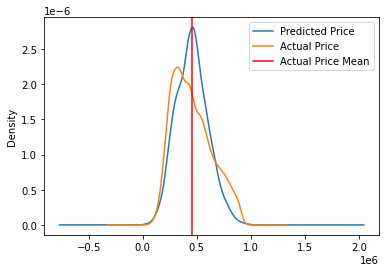

In [81]:
x_mean = df['price'].mean()
df.head()
df['PredictedPrice'].plot.kde(label='Predicted Price')
df['price'].plot.kde(label='Actual Price')
plt.axvline(x_mean, 0, 5,label='Actual Price Mean', c='r')
plt.legend()

# graph below shows that our model is missing some information and is anticipating a more normal distribution whereas the actual home sales are skewed towards the lower price range. 
# the distribution of home prices leans to and peaks to the left of the mean home price, indicating positive skewness in the actual home price sales. This is also why our predictive model
# peaks right at the actual price mean!

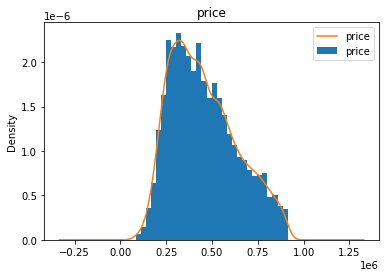

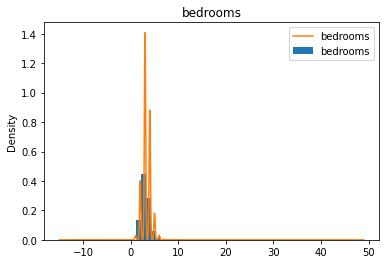

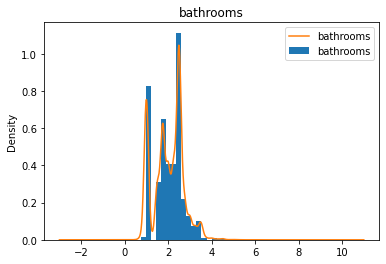

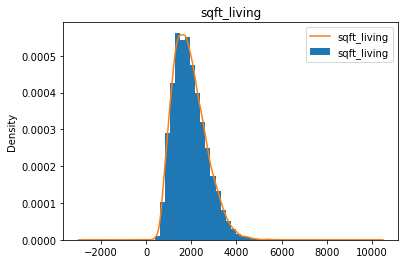

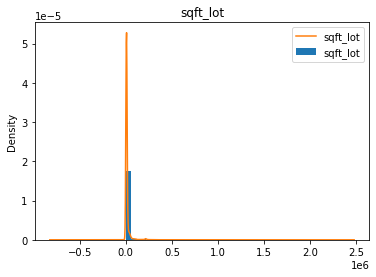

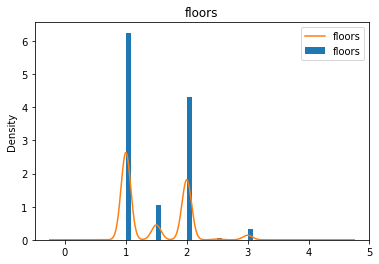

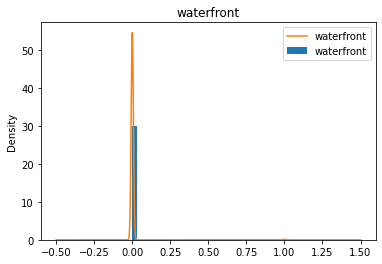

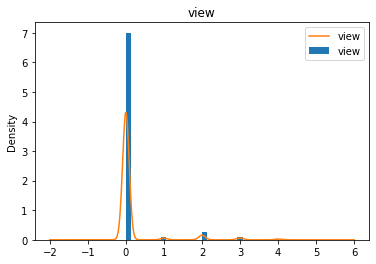

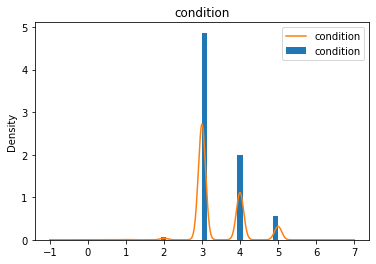

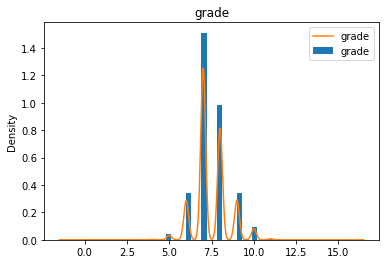

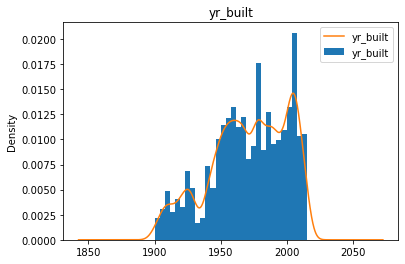

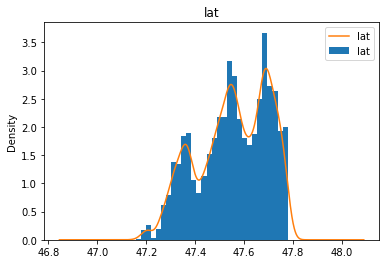

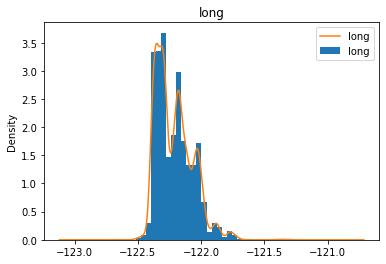

In [82]:
# what can we remove from the model?

for column in ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','yr_built','lat','long']:
    df[column].plot.hist(density = True, bins = 30)
    df[column].plot.kde()
    plt.title(column)
    plt.legend()
    plt.show()


### In the above graphs we can see similarity in the shape of latitude histogram as well as year built. This means that as year built increases so does how far north the home was built. This implies multicollinearity between these two features and for a final predictive model one will need to be removed. Let's look at a coefficient table next. 

In [83]:
# steps right now 1- build a coefficient table 2- keep features with a graph similar to price, get rid of any that are not similarly shaped 3- get rid of any features where coefficient is small when multiplied by a feature (minimal impact on price)
# suspect waterfront is minimally affecting the model with a small coefficient (it is not a minimal impact after all) 
y_target = 'price'
x_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','lat','long']
formula = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+lat+long+yr_built'
lm = ols(formula=formula, data=df).fit()

In [84]:
lm.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2360.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:40:40   Log-Likelihood:            -1.8584e+05
No. Observations:               14314   AIC:                         3.717e+05
Df Residuals:                   14301   BIC:                         3.718e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.587e+07   9.49e+05    -16.732      0.000   -1.77e+07    -1.4e+07
bedrooms    -7428.3447   1236.598     -6.007      0.000   -9852.237   -5004.453
bathrooms    2.102e+04   2134.498      9.847      0.000    1.68e+04    2.52e+04
sqft_living    80.4805      2.223     36.211      0.000      76.124      84.837
sqft_lot        0.1913      0.024      8.108      0.000       0.145       0.238
floors       2.787e+04   2089.405     13.337      0.000    2.38e+04     3.2e+04
waterfront   1.194e+05   1.87e+04      6.384      0.000    8.28e+04    1.56e+05
view         2.804e+04   1622.303     17.286      0.000    2.49e+04    3.12e+04
condition     2.23e+04   1483.074     15.034      0.000    1.94e+04    2.52e+04
grade        7.412e+04   1386.645     53.456      0.000    7.14e+04    7.68e+04
lat          5.181e+05   6465.518     80.139      0.000    5.05e+05    5.31e+05
long         4.892e+04   7130.095      6.860      0.000    3.49e+04    6.29e+04
yr_built    -1615.8692     46.062    -35.080      0.000   -1706.157   -1525.581
==============================================================================
Omnibus:                      643.528   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              952.790
Skew:                           0.418   Prob(JB):                    1.27e-207
Kurtosis:                       3.947   Cond. No.                     4.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

In [85]:
# Let's repeat this analysis with some common sense to reduce any other slight multicollinearity. Sqft_living and number of floors are probably correlated, so I will test the model and remove either while keeping the rest of the model the same in order to see which one is contributing to the model the most and keep that one. I will then do the same with yr_built and latitude sine they appear to be also have their own correlation.

In [117]:
y_target = 'price'
formula = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+waterfront+view+condition+grade+lat+long+yr_built'
lm = ols(formula=formula, data=df).fit()

In [118]:
lm.summary()
# removing floors has a smaller impact on r^2 than removing sqft_living and so I will remove it from the final model. 

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2527.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:16:07   Log-Likelihood:            -1.8593e+05
No. Observations:               14314   AIC:                         3.719e+05
Df Residuals:                   14302   BIC:                         3.720e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.724e+07   9.49e+05    -18.163      0.000   -1.91e+07   -1.54e+07
bedrooms    -8216.3271   1242.800     -6.611      0.000   -1.07e+04   -5780.277
bathrooms    2.762e+04   2089.067     13.222      0.000    2.35e+04    3.17e+04
sqft_living    79.3433      2.235     35.507      0.000      74.963      83.723
sqft_lot        0.1782      0.024      7.516      0.000       0.132       0.225
waterfront   1.231e+05   1.88e+04      6.542      0.000    8.62e+04     1.6e+05
view         2.721e+04   1631.083     16.680      0.000     2.4e+04    3.04e+04
condition     1.98e+04   1480.255     13.374      0.000    1.69e+04    2.27e+04
grade        7.689e+04   1379.482     55.739      0.000    7.42e+04    7.96e+04
lat           5.24e+05   6490.209     80.741      0.000    5.11e+05    5.37e+05
long          4.22e+04   7156.125      5.897      0.000    2.82e+04    5.62e+04
yr_built    -1472.5892     45.068    -32.675      0.000   -1560.928   -1384.250
==============================================================================
Omnibus:                      603.477   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.413
Skew:                           0.409   Prob(JB):                    1.97e-188
Kurtosis:                       3.883   Cond. No.                     4.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

In [119]:
y_target = 'price'
formula = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+waterfront+view+condition+grade+lat+long'
lm = ols(formula=formula, data=df).fit()

In [120]:
lm.summary()
# removing lat versus removing yr_built substantially lowers the r^2. as a result, will keep 'lat' in the predictive model. 

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2487.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:16:14   Log-Likelihood:            -1.8644e+05
No. Observations:               14314   AIC:                         3.729e+05
Df Residuals:                   14303   BIC:                         3.730e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.136e+07   8.76e+05    -35.817      0.000   -3.31e+07   -2.96e+07
bedrooms    -5410.5850   1285.229     -4.210      0.000   -7929.801   -2891.369
bathrooms   -1042.1892   1965.363     -0.530      0.596   -4894.555    2810.177
sqft_living    92.7648      2.277     40.741      0.000      88.302      97.228
sqft_lot        0.2255      0.025      9.190      0.000       0.177       0.274
waterfront    1.16e+05   1.95e+04      5.945      0.000    7.77e+04    1.54e+05
view          3.27e+04   1681.803     19.443      0.000    2.94e+04     3.6e+04
condition    3.451e+04   1461.747     23.608      0.000    3.16e+04    3.74e+04
grade        6.267e+04   1356.916     46.183      0.000       6e+04    6.53e+04
lat          5.693e+05   6572.495     86.625      0.000    5.56e+05    5.82e+05
long        -3.265e+04   7027.867     -4.646      0.000   -4.64e+04   -1.89e+04
==============================================================================
Omnibus:                      753.397   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1006.315
Skew:                           0.506   Prob(JB):                    3.03e-219
Kurtosis:                       3.815   Cond. No.                     3.98e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

In [130]:
# time to redo the training and testing of our variables after having eliminated some features
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','waterfront','view','condition','grade','lat','long']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 20) # create test and train variables, assign random state for reproducibility

In [131]:
reg = LinearRegression(fit_intercept=True) # create linear regression
reg.fit(X_train,y_train) # fit the model

LinearRegression()

In [132]:
# evaluate the model on the testing data
a1 = reg.score(X_test, y_test)
X_train.shape
a1

0.6286304482241847

In [133]:
r2train = reg.score(X_train, y_train)
r2test = reg.score(X_test, y_test) 
num_obtrain = X_train.shape[0]
num_obtest = X_test.shape[0]
ptrain = X_train.shape[1]
ptest = X_test.shape[1]

In [134]:
# compare the r2 scores of the model on the training and test data
r2tra, r2tes = reg.score(X_train,y_train),reg.score(X_test,y_test)
print(r2tra)
print(r2tes)

#a adjusted r^2 for the data is telling us that this model's features explain ~66% of the change in price

0.636386743250181
0.6286304482241847


In [135]:
# calc adjusted r squared and VIF score for training data
clc(r2tra,num_obtrain,ptrain)

In [136]:
# calc adjusted r squared and VIF score for training data
clc(r2tes,num_obtest,ptest)

In [137]:
df['PredictedPrice2'] = reg.predict(X) # create a column with a new predicted price to compare graphs of the models predictions vs. the actual prices of homes version 2

&lt;matplotlib.legend.Legend at 0x1d311838580&gt;

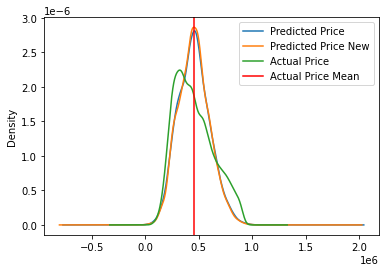

In [138]:
x_mean = df['price'].mean()
df.head()
df['PredictedPrice'].plot.kde(label='Predicted Price')
df['PredictedPrice2'].plot.kde(label='Predicted Price New')
df['price'].plot.kde(label='Actual Price')
plt.axvline(x_mean, 0, 5,label='Actual Price Mean', c='r')
plt.legend()

## Question 1 - What effect do number of bedrooms and bathrooms have on the sales price of a home? 

## Question 2 - Is temporary condition or overall grade more important to home price?

## Question 3 - What 5 features most affect home price?